# Obtaining the data from the Mona File

## Getting the path for Mona file

Using the method load_from_msp, the information inside the Mona file is being obtained.

In [1]:
import os

path = os.path.join(os.path.dirname(os.getcwd()), "data")
spectrums_file = os.path.join(path, "MoNA-export-GC-MS.msp")

## Appliying filters to the spectra

Applied filters are:
* normalize_intensities(s)
* reduce_to_number_of_peaks(s, **n_required=10**, **ratio_desired=0.5**)
* select_by_mz(s, **mz_from=0**, **mz_to=1000**)
* require_minimum_number_of_peaks(s, **n_required=10**)

In [2]:
from matchms.filtering import normalize_intensities
from matchms.filtering import reduce_to_number_of_peaks
from matchms.filtering import select_by_mz
from matchms.filtering import require_minimum_number_of_peaks
from matchms.importing import load_from_msp

def apply_my_filters(s):
    s = normalize_intensities(s)
    s = reduce_to_number_of_peaks(s, n_required=10, ratio_desired=0.5)
    s = select_by_mz(s, mz_from=0, mz_to=1000)
    s = require_minimum_number_of_peaks(s, n_required=10)
    return s

spectrums = [apply_my_filters(s) for s in load_from_msp(spectrums_file)]

spectrums = [s for s in spectrums if s is not None]

## Converting Spectrum objects to Spectrum Documents

In [3]:
from spec2vec import SpectrumDocument

reference_documents = [SpectrumDocument(s) for s in spectrums]

## Training the word2vec model

Data used for training the model:\
**Iterarions=10, 20, 30**\
**Workers=2**

Once the model is trained the file "references.model" is stored for further use in the score calculation

In [4]:
from spec2vec.model_building import train_new_word2vec_model

model_file = os.path.join(path, "references.model")
model = train_new_word2vec_model(documents=reference_documents, filename=model_file, 
                                 iterations=[10, 20, 30], workers=2, progress_logger=False)

The value of workers is set from 4 (default) to 2
Saving model with name: /Users/efra/dev/spec2vec_gcms_data_analysis/data/references_iter_10.model
Saving model with name: /Users/efra/dev/spec2vec_gcms_data_analysis/data/references_iter_20.model
Saving model with name: /Users/efra/dev/spec2vec_gcms_data_analysis/data/references.model


## Setting the reference and query data

The first 10 Spectra in the Monna file will be used to try to find them using the Spec2VecParallel method

In [5]:
spectrums_file_10 = os.path.join(path, "MoNA-export-GC-MS-first10.msp")

### Setting the reference Spectrums

In [6]:
reference_spectrums = [apply_my_filters(s) for s in load_from_msp(spectrums_file_10)]

reference_spectrums = [s for s in reference_spectrums if s is not None]

### Converting the reference Spectrums to Spectrums Documents

In [7]:
reference_documents = [SpectrumDocument(s) for s in reference_spectrums]

### Setting the query Spectrums

In [8]:
query_spectrums = [apply_my_filters(s) for s in load_from_msp(spectrums_file_10)]

query_spectrums = [s for s in query_spectrums if s is not None]

### Converting the query Spectrums to Spectrums Documents

In [9]:
query_documents = [SpectrumDocument(s) for s in query_spectrums]

### Loading the model file to word2vec for the similarity function

Parameters for the similarity function:\
**intensity_weighting_power=0.5**\
**allowed_missing_percentage=5.0**

In [10]:
import gensim
from matchms import calculate_scores_parallel
from spec2vec import Spec2VecParallel

model = gensim.models.Word2Vec.load(model_file)

# Define similarity_function
spec2vec = Spec2VecParallel(model=model, intensity_weighting_power=0.5,
                            allowed_missing_percentage=5.0)

### Calculating the similarity of the reference and query documents using Spec2vec parallel method

For the calculation the same Spectrums are being used as reference and query

In [12]:
#filename = os.path.join(path_data,'similarities_spec2vec_2dec_AllPositiveModel_15iter.npy')
#np.save(filename, similarity_matrix)

scores = list(calculate_scores_parallel(reference_documents, query_documents, spec2vec))


In [13]:
# Filter out self-comparisons
filtered = [(reference, query, score) for (reference, query, score) in scores if reference != query]


In [14]:
sorted_by_score = sorted(filtered, key=lambda elem: elem[2], reverse=True)

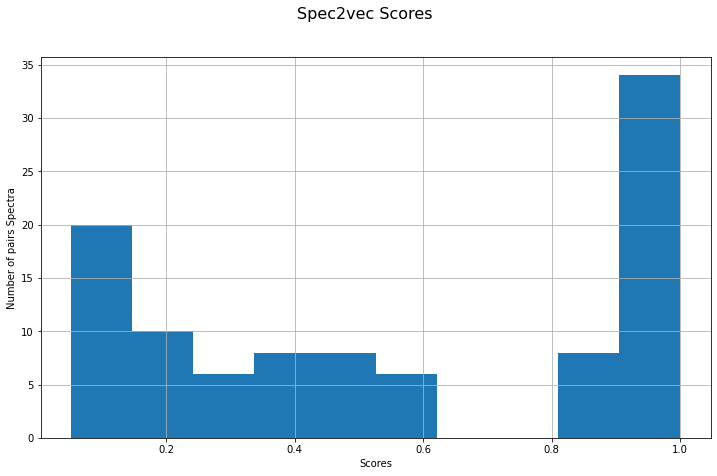

In [15]:
import matplotlib.pyplot as plt

def print_histogram(data, title=None):
    plt.figure(figsize=(12,7))
    plt.grid(True)
    hist = plt.hist(data)
    if title is not None:
        plt.suptitle(title, fontsize=16)
    plt.xlabel("Scores")
    plt.ylabel("Number of pairs Spectra")
    plt.show()

scores = [score for (reference, query, score) in sorted_by_score]

print_histogram(scores, "Spec2vec Scores")

['peak@51.0', 'peak@53.0', 'peak@59.0', 'peak@60.0', 'peak@61.0', 'peak@62.0', 'peak@63.0', 'peak@64.0', 'peak@65.0', 'peak@66.0', 'peak@67.0', 'peak@69.0', 'peak@71.0', 'peak@72.0', 'peak@73.0', 'peak@74.0', 'peak@75.0', 'peak@79.0', 'peak@80.0', 'peak@81.0', 'peak@82.0', 'peak@83.0', 'peak@84.0', 'peak@85.0', 'peak@86.0', 'peak@87.0', 'peak@89.0', 'peak@95.0', 'peak@96.0', 'peak@97.0', 'peak@98.0', 'peak@99.0', 'peak@100.0', 'peak@106.0', 'peak@107.0', 'peak@108.0', 'peak@109.0', 'peak@131.0', 'peak@132.0', 'peak@133.0', 'peak@134.0', 'peak@135.0', 'peak@136.0', 'peak@137.0', 'peak@149.0', 'peak@151.0', 'peak@160.0', 'peak@161.0', 'peak@162.0', 'peak@163.0', 'peak@164.0', 'peak@167.0', 'peak@169.0', 'peak@177.0', 'peak@179.0', 'peak@192.0', 'peak@194.0', 'peak@195.0', 'peak@196.0', 'peak@197.0', 'peak@198.0', 'peak@199.0', 'peak@200.0', 'peak@201.0', 'peak@202.0']
0.35107720670813736


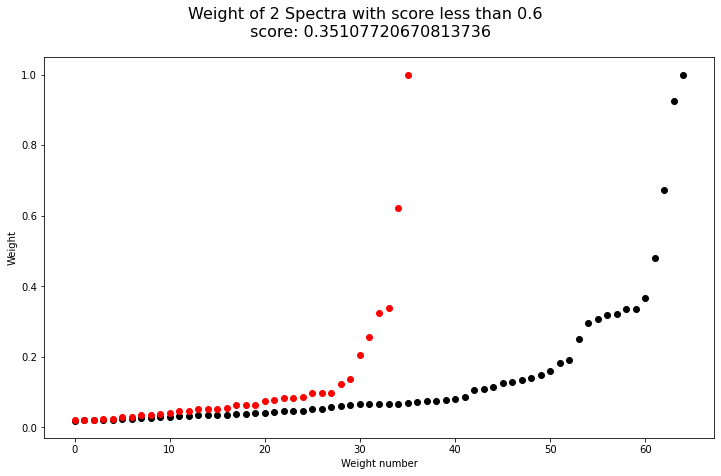

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import random

def plt_scatterd_weights(reference, query, title):
    plt.figure(figsize=(12, 7))
    plt.suptitle(title, fontsize=16) ptho
    plt.xlabel("Weight number")
    plt.ylabel("Weight")
    for k, s in enumerate(sorted(reference.weights)):
        plt.plot(k, s, 'o', color='black')
        
    for k, s in enumerate(sorted(query.weights)):
        plt.plot(k, s, 'o', color='red')
    plt.show()


scores_low_score = [(reference, query, score) for (reference, query, score) in sorted_by_score if score < 0.6]

sample = random.sample(scores_low_score, 1)[0]
print(sample[0])
print(sample[2])

plt_scatterd_weights(sample[0], sample[1], "Weight of 2 Spectra with score less than 0.6 \n score: " + str(sample[2]))

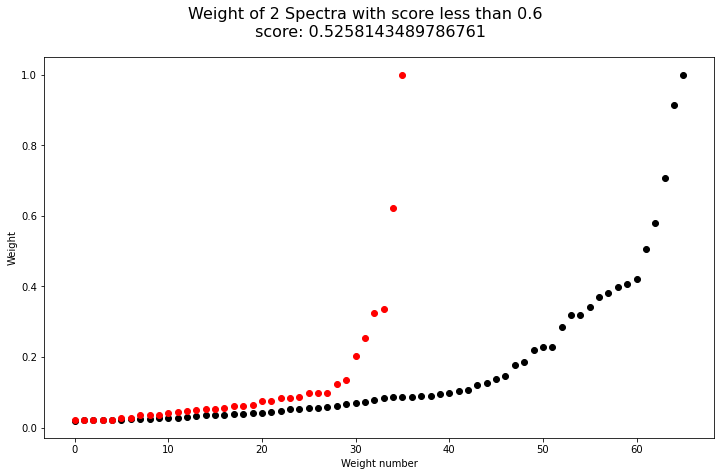

In [17]:
sample = random.sample(scores_low_score, 1)[0]

plt_scatterd_weights(sample[0], sample[1], "Weight of 2 Spectra with score less than 0.6 \n score: " + str(sample[2]))

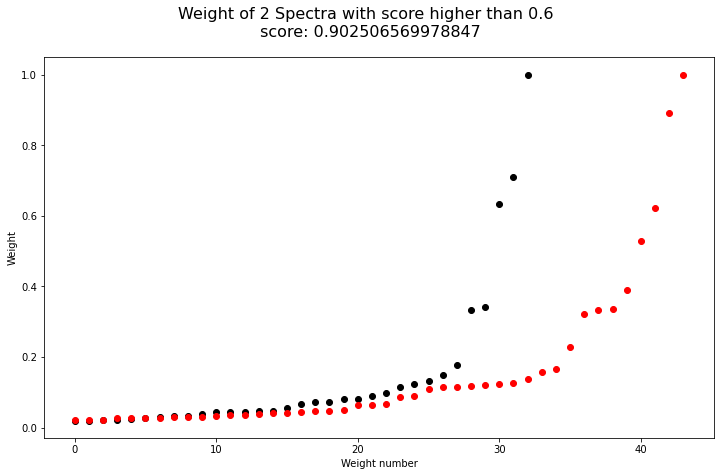

In [18]:
scores_low_score = [(reference, query, score) for (reference, query, score) in sorted_by_score if score > 0.6]

sample = random.sample(scores_low_score, 1)[0]

plt_scatterd_weights(sample[0], sample[1], "Weight of 2 Spectra with score higher than 0.6 \n score: " + str(sample[2]))

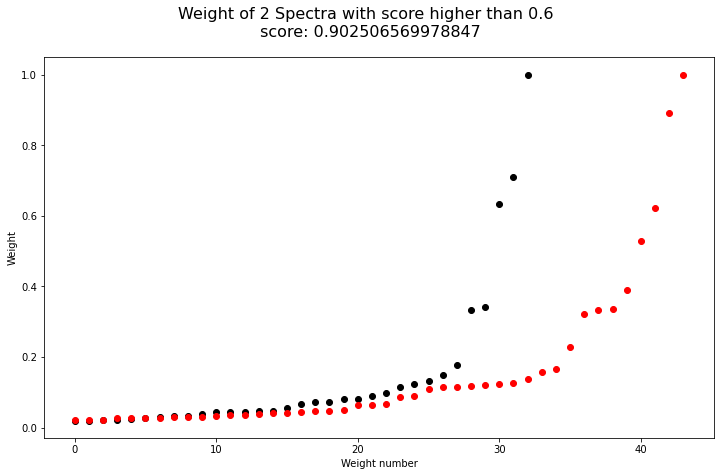

In [19]:
sample = random.sample(scores_low_score, 1)[0]

plt_scatterd_weights(sample[0], sample[1], "Weight of 2 Spectra with score higher than 0.6 \n score: " + str(sample[2]))